# Simulation_CLP_PID_FF


In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import colors as mcolors

from importlib import reload

import package_DBR
from package_DBR import myRound, SelectPath_RT, Delay_RT, FO_RT, FOPDT, SOPDT, FOPDT_cost, SOPDT_cost, Process, Bode

import package_LAB
package_LAB = reload(package_LAB)
from package_LAB import LL_RT, LL, PID_RT, IMC

## Simulation Parameters

In [121]:
UseFF = True
ManFF = False

alpha = 1
MVMin = 0
MVMax = 100

## Values from experiment + optimization

In [122]:
K_SOPDT_OPT = 0.3562231735602847
T1_SOPDT_OPT = 164.90136281744202
T2_SOPDT_OPT = 41.937854162157095
theta_SOPDT_OPT = 1.058634883965729

K_SOPDT_OPT_DV = 0.3470577806298568
T1_SOPDT_OPT_DV = 160.56027097048144
T2_SOPDT_OPT_DV = 35.99302014643125
theta_SOPDT_OPT_DV = 9.177287203018302

## Feed-forward time constants & dead-time

In [123]:
K_FF = -K_SOPDT_OPT_DV/K_SOPDT_OPT
print(K_FF)
thetaFF = max([0, theta_SOPDT_OPT_DV - theta_SOPDT_OPT])

TLEAD_LL1 = T1_SOPDT_OPT
TLAG_LL1 = T1_SOPDT_OPT_DV

TLEAD_LL2 = T2_SOPDT_OPT
TLAG_LL2 = T2_SOPDT_OPT_DV


-0.9742706437685564


## Calculate IMC Values


In [124]:
gammas = [0.2, 0.5]

Kcs = []
Tis = []
Tds = []

for gamma in gammas:
    Kc, Ti, Td = IMC(K_SOPDT_OPT, T1_SOPDT_OPT, T2_SOPDT_OPT, theta_SOPDT_OPT, gamma)
    Kcs.append(Kc)
    Tis.append(Ti)
    Tds.append(Td)

## Process Simulation

In [125]:
MV0 = 50
DV0 = 50

PV0 = 49.4

TypeError: unhashable type: 'list'

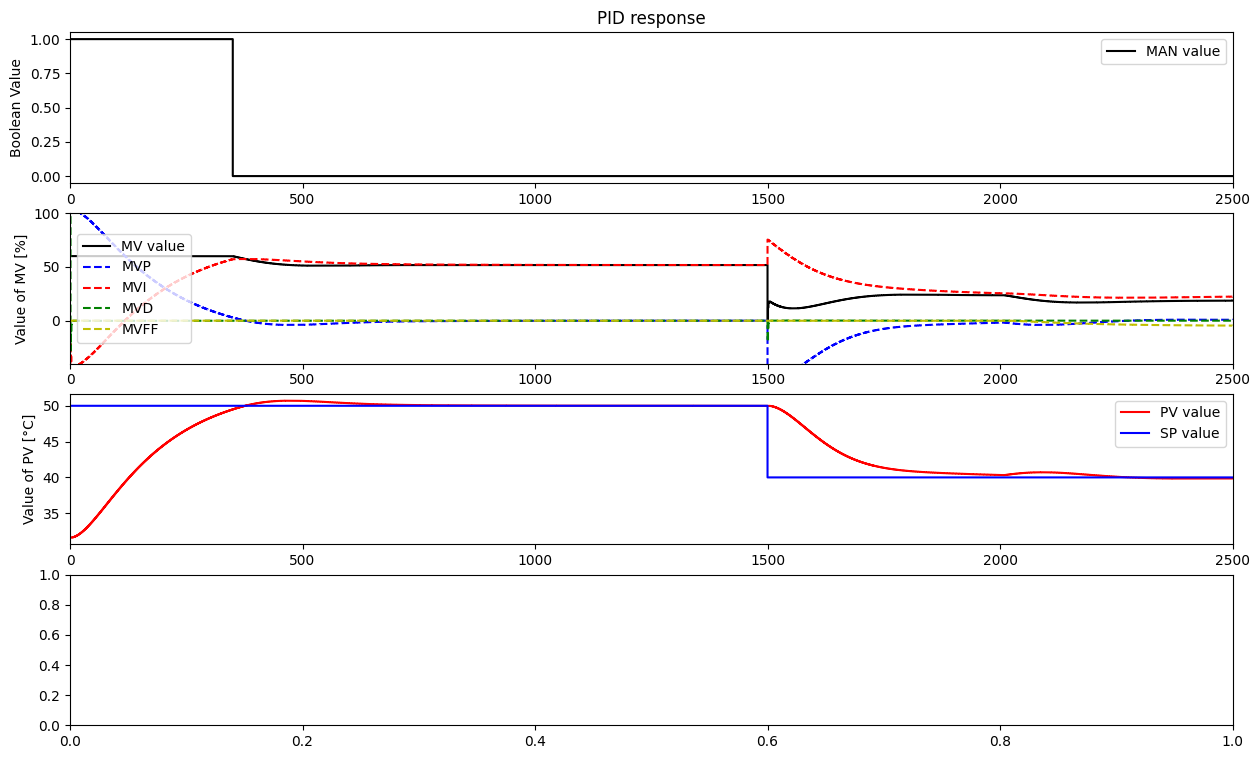

In [ ]:
TSim = 2500
Ts = 1
N = int(TSim/Ts) + 1
Treach = 350 #Time to reach first setpoint

# Path for variables
MVManPath = {0:60, TSim:60}
DVPath = {0: 50, 2000: 55, TSim : 55}
SPPath = {0: 50, 1500: 40, TSim : 40}

ManPath = {0: True, Treach: False, TSim : False}


t = []
DV = []
SP = []
PV = []

MVFF_Delay = []
MVFF_LL1 = []

MV = []
MVP = []
MVI = []
MVD = []

MV_Delay_Process = []
PV_1_Process = []
PV_Process = []

MV_Delay_Disturb = []
PV_1_Disturb = []
PV_Disturb = []

Man = []
MVMan = []
MVFF = []
E = []


for i in range(0,N):
    t.append(i*Ts)
    SelectPath_RT(DVPath, t, DV)
    SelectPath_RT(SPPath,t,SP)
    SelectPath_RT(ManPath,t,Man)
    SelectPath_RT(MVManPath,t,MVMan)
    # Feed-Forward
    Delay_RT(DV-DV0*np.ones_like(DV),thetaFF,Ts,MVFF_Delay,0)

    LL_RT(MVFF_Delay,K_FF,TLEAD_LL1,TLAG_LL1,Ts,MVFF_LL1,0)
    if UseFF:
        LL_RT(MVFF_LL1, 1, TLEAD_LL2, TLAG_LL2, Ts, MVFF, 0)
    else:
        LL_RT(MVFF_LL1, 0, TLEAD_LL2, TLAG_LL2, Ts, MVFF, 0)
    # PID
    PID_RT(SP, PV, Man, MVMan, MVFF, Kc, Ti, Td, alpha, Ts, MVMin, MVMax, MV, MVP, MVI, MVD, E)
    # Process
    # Input-output dynamics P(s)
    Delay_RT(MV,theta_SOPDT_OPT,Ts,MV_Delay_Process,MV0)
    FO_RT(MV_Delay_Process,K_SOPDT_OPT,T1_SOPDT_OPT,Ts,PV_1_Process,0)
    FO_RT(PV_1_Process,1,T2_SOPDT_OPT,Ts,PV_Process,0)

    # Disturb  ce dynamics D(s)
    Delay_RT(DV - DV0*np.ones_like(DV),theta_SOPDT_OPT_DV,Ts,MV_Delay_Disturb,0)
    FO_RT(MV_Delay_Disturb,K_SOPDT_OPT_DV,T1_SOPDT_OPT_DV,Ts,PV_1_Disturb,0)
    FO_RT(PV_1_Disturb,1,T2_SOPDT_OPT_DV,Ts,PV_Disturb,0)
    PV.append(PV_Process[-1] + PV_1_Disturb[-1] + PV0-K_SOPDT_OPT*MV0)


plt.figure(figsize = (15,9))
plt.subplot(4,1,1)
plt.step(t,Man,'black',label='MAN value',where='post')
plt.ylabel('Boolean Value')
plt.title('PID response')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,2)
plt.step(t,MV,'black',label='MV value',where='post')
plt.step(t, MVP, 'b--', label='MVP', where='post')
plt.step(t, MVI, 'r--', label='MVI', where='post')
plt.step(t, MVD, 'g--', label='MVD', where='post')
plt.step(t, MVFF, 'y--', label='MVFF', where='post')
plt.ylabel('Value of MV [%]')
plt.legend(loc='best')
plt.xlim([0, TSim])
plt.ylim([-40, 100])

plt.subplot(4,1,3)
plt.step(t,PV,'red',label='PV value',where='post')
plt.step(t,SP,'blue',label='SP value',where='post')
plt.ylabel('Value of PV [°C]')
plt.legend(loc='best')
plt.xlim([0, TSim])

plt.subplot(4,1,4)
plt.step(t, DV, 'black', label='DV value', where='post')
plt.ylabel('Value of DV [%]')
plt.legend(loc='best')
plt.xlim([0, TSim])

